# Examples

## Example: Vandermonde matrix

$$ \begin{align}V=\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}\end{align} $$

### Python / numpy

<p><img src="../images/numpy_vander.png" alt="drawing" width="1500"/></p>

(The source code for this function is [here](https://github.com/numpy/numpy/blob/v1.16.1/numpy/lib/twodim_base.py#L475-L563). It calls `np.multiply.accumulate` which is implemented in C [here](https://github.com/numpy/numpy/blob/deea4983aedfa96905bbaee64e3d1de84144303f/numpy/core/src/umath/ufunc_object.c#L3678). However, this code doesn't actually perform the computation, it basically only checks types and stuff. The actual kernel that gets called is [here](https://github.com/numpy/numpy/blob/deea4983aedfa96905bbaee64e3d1de84144303f/numpy/core/src/umath/loops.c.src#L1742). This isn't even C code but a template for C code which is used to generate type specific kernels.)

**Overall, this setup only supports a limited set of types, like `Float64`, `Float32`, and so forth.**


### Julia

Here is a simple generic Julia implementation


In [ ]:
function vander(x::AbstractVector{T}) where T
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = one(x[j])
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

In [ ]:
vander(1:5)

#### Quick speed comparison

<img src="../images/vandermonde.svg" alt="drawing" width="600"/>

Note that the clean and concise Julia implementation is **beating numpy's C implementation for small matrices** and is **on-par for large matrix sizes**.

At the same time, **the Julia code is *generic* and works for arbitrary types!**


In [ ]:
vander(Int32[4, 8, 16, 32])

It even works for non-numerical types. The only requirement is that the type has a *one* (identity element) and a multiplication operation defined.


In [ ]:
vander(["This", "also", "works"])

### Emergent feature: Symbolic computing

In [ ]:
using Symbolics

In [ ]:
@variables a b c d e

In [ ]:
v = vander([a,b,c,d,e])

In [ ]:
substitute(v, Dict(b => 2, d => 4))

## Emergent feature: Differential equation solving with uncertainty

In [ ]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = 5.730 ± 2

#Setup
u0 = 1.0 ± 0.1
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false, frame=:box)

**Historical note**: In some sense, **Julia implemented that feature by itself**. The authors of Measurements.jl and DifferentialEquations.jl [never had any collabration on this](https://discourse.julialang.org/t/differentialequations-jl-and-measurements-jl/6350).

## Neural Networks

In [14]:
using Flux, Statistics, ProgressMeter

device = gpu_device()

# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),      # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2)
) |> device  # move model to GPU, if one is available

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 548 bytes.

In [15]:
# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> device)    # 2×1000 Matrix{Float32}, or CuArray{Float32}
probs1 = softmax(out1) |> cpu    # normalise to get probabilities (and move off GPU)

2×1000 Matrix{Float32}:
 0.522681  0.619197  0.733935  0.73305  …  0.685643  0.605253  0.565813
 0.477319  0.380803  0.266065  0.26695     0.314357  0.394747  0.434187

In [16]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target), batchsize=64, shuffle=true);
opt_state = Flux.setup(Flux.Adam(0.01), model);  # will store optimiser momentum, etc.

In [17]:
# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for xy_cpu in loader
        # Unpack batch of data, and move to GPU:
        x, y = xy_cpu |> device
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.logitcrossentropy(y_hat, y)
        end
        Flux.update!(opt_state, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [18]:
out2 = model(noisy |> device)         # first row is prob. of true, second row p(false)
probs2 = softmax(out2) |> cpu         # normalise to get probabilities
mean((probs2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!

0.982

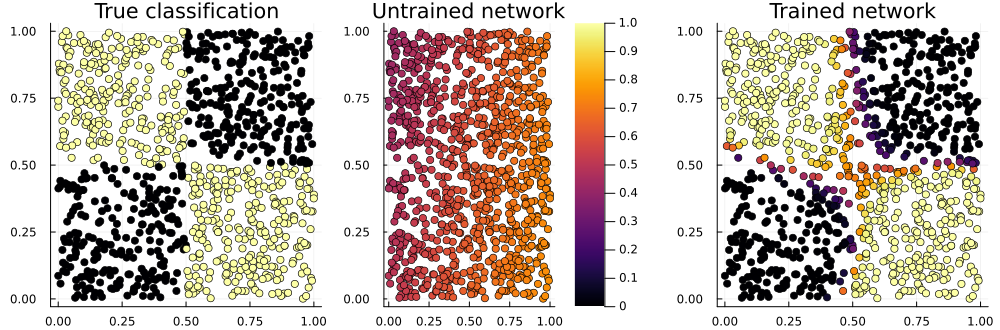

In [19]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=probs1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=probs2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

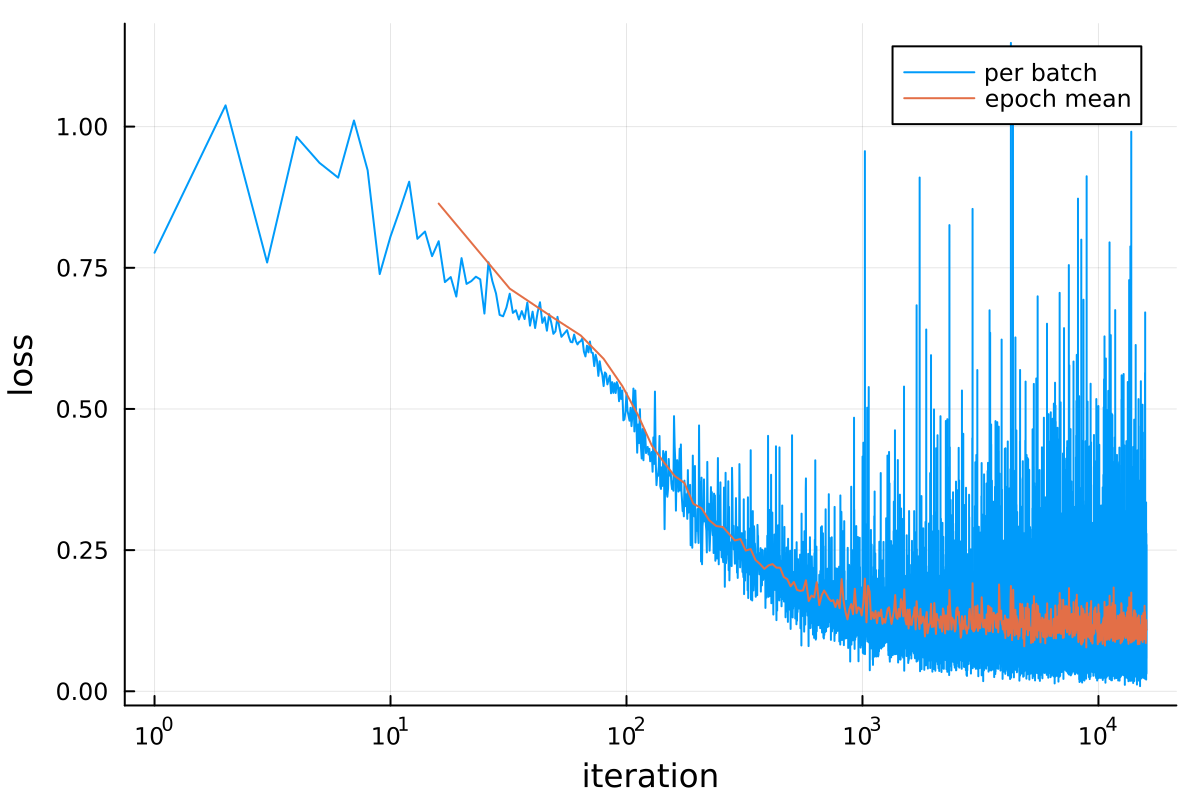

In [20]:
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean", dpi=200)